# ML on IFE data

**In this notebook:**
- A dictionary is created to make it easy to access all data
    - One for all cells and others for the subsets of cells
- A simple Elastic Net model is created
    - Cycle life defined as the normalized cycle number when normalized capacity reaches 90% (first c20 cycle when this occurs)
    - Features are generated from the difference between the first and last C20 cycle, common name c20_diff
        - variance and mean of Qd_c20_diff, dQdV_c20_diff, total 4 features
- Next step will be to
    - Seperate cells with similar cycling conditions (Concern: too few samples)
    - Include more features
    - Find out how to make model with the rest of the cycling data

\
\
- interpolere sykler med forskjellig lengde i scipy eller pandas. Qd og V, kan ikke anta at data er fast inkrement på spenningssteg (indeks tilsvarer spenningspunkter). Tenk at Qd hadde vært funksjon av tid, måtte da gjort om til Q(V) istedenfor Q(t). Gjør interpoleringen i annet script siden dette fungerer.
- halvtime hver dag med skriving
- Definer cycle life som kapasiteten etter et visst antall sykluser? eller RUL?

\
\
Last edit: 26.04.2022


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, random
import pathlib
import glob
from matplotlib import style
from sklearn.preprocessing import minmax_scale, normalize, MinMaxScaler

pd.set_option('display.max_columns', 100)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RepeatedKFold, KFold
from functions import get_errors, get_errors2
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import iqr

### Cell dictionaries

This cell creates a dictionary for each group of cells. The groups are created based on the varying cycling conditions.

- 4 groups of different SOC windows: soc100, soc80, soc40, and soc10
- 5 groups of different temperatures: T5, T15, T25, T35, and T45
- 3 groups of different C-rates: 0.4C, 0.75C, and 1.5C
- 1 group of all cycled cells

In [14]:
# Path to group files containing the cell_ids in each group
groups = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\groups"
# Path to cell data files
path_cells = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\data\IFE\interim"

# Cells that have missing cycle 115 or 15 data, FIXED
#exclude = ['Cell_ID_SK04A27576', 'Cell_ID_SK04A2C604', 'Cell_ID_SK04A2D012', 'Cell_ID_SK05A14198', 'Cell_ID_SK05A15215',\
#          'Cell_ID_SK05A30027', 'Cell_ID_SK04A2B993']

bat_dict = {}

for file in (os.listdir(groups)):
    group = file[:-4] # drop .txt
    bat_dict[group] = {}
    infile = open(os.path.join(groups, file))
    cells = infile.readlines()
    print(group)
    for cell in cells:
        cell = 'Cell_ID_' + cell.strip('\n')
        bat_dict[group][cell] = {} # each cell is a new dictionary


        # Make summary dataframes
        cell_dir = os.path.join(path_cells, cell)
        summary_file = os.path.join(cell_dir, os.listdir(cell_dir)[1])
        summary_df = pd.read_csv(summary_file, encoding = "ISO-8859-1", sep='\t')



        # Make list of all C20 cycles
        c20_dir = os.path.join(path_cells, cell+'\C20_cycles')

        charge_cycles = []
        discharge_cycles = []

        # Charge 
        for charge_cycle in glob.glob(os.path.join(c20_dir, '*cha.txt')):
            charge_cycle_file = os.path.join(c20_dir, charge_cycle)
            charge_cycle_df = pd.read_csv(charge_cycle_file, encoding = "ISO-8859-1", sep='\t')
            charge_cycles.append(charge_cycle_df)

        # Discharge
        for discharge_cycle in glob.glob(os.path.join(c20_dir, '*dch.txt')):
            discharge_cycle_file = os.path.join(c20_dir, discharge_cycle)
            discharge_cycle_df = pd.read_csv(discharge_cycle_file, encoding = "ISO-8859-1", sep='\t')
            discharge_cycles.append(discharge_cycle_df)

        # Make list of all IR cycles
        IR_dir = os.path.join(path_cells, cell+'\IR_cycles')
        IR_cycles = []
        for IR_cycle in os.listdir(IR_dir):
            IR_cycle_file = os.path.join(IR_dir, IR_cycle)
            IR_cycle_df = pd.read_csv(IR_cycle_file, encoding = "ISO-8859-1", sep='\t')
            IR_cycles.append(IR_cycle_df)





        # Make dataframes of the 15th and 115th cycle, regular and normalized

        # Find files in cell directory
        c15_file = glob.glob(os.path.join(cell_dir, '*_C15.txt'))[0]
        c15_norm_file = glob.glob(os.path.join(cell_dir, '*_C15_norm.txt'))[0]
        c115_file = glob.glob(os.path.join(cell_dir, '*_C115.txt'))[0]
        c115_norm_file = glob.glob(os.path.join(cell_dir, '*_C115_norm.txt'))[0]

        # make dataframes
        c15_df = pd.read_csv(c15_file, encoding = "ISO-8859-1", sep='\t')
        c15_df_norm = pd.read_csv(c15_norm_file, encoding = "ISO-8859-1", sep='\t')
        c115_df = pd.read_csv(c115_file, encoding = "ISO-8859-1", sep='\t')
        c115_df_norm = pd.read_csv(c115_norm_file, encoding = "ISO-8859-1", sep='\t')

        # Add data to dictionary
        bat_dict[group][cell]['summary'] = summary_df
        bat_dict[group][cell]['C20 charge'] = charge_cycles
        bat_dict[group][cell]['C20 discharge'] = discharge_cycles
        bat_dict[group][cell]['IR cycles'] = IR_cycles
        bat_dict[group][cell]['c15'] = c15_df
        bat_dict[group][cell]['c15 normalized'] = c15_df_norm
        bat_dict[group][cell]['c115'] = c115_df
        bat_dict[group][cell]['c115 normalized'] = c115_df_norm

04C
075C
150C
All
MP
NoMP
NoT5
soc10
soc100
soc40
soc80
T15
T25
T35
T45
T5


In [25]:
print(bat_dict.keys())

dict_keys(['04C', '075C', '150C', 'All', 'MP', 'NoMP', 'NoT5', 'soc10', 'soc100', 'soc40', 'soc80', 'T15', 'T25', 'T35', 'T45', 'T5'])


### Overview of cell dictionary

In [26]:
bat_dict['075C']['Cell_ID_Sk05A23761']['summary']

,Date and Time,Time stamp,Total time (days),Total test time (days),Position,Tasks,CellUnit,Cycle - actual,Cycle - normalized,Cycle - total,Cycle - total - normalized,Cycle length (h),Current_dch (C),Current_dch std dev (C),Current_dch_end (C),Current_cha (C),Current_cha std dev (C),Current_cha_end (C),Temp avg (°C),Temp std dev (°C),Temp dch start (°C),Temp dch avg (°C),Temp dch max (°C),Temp dch std dev (°C),Temp cha start (°C),Temp cha avg (°C),Temp cha max (°C),Temp cha std dev (°C),Voltage EoD (V),Voltage EoC (V),Voltage EoD ocv (V),Voltage EoC ocv (V),Voltage charge avg (V),Voltage discharge avg (V),Ah_dch (Ah),Ah_cha (Ah),Ah_dch (nominal) (%),Ah_dch (C20 first) (%),Ah_cha (nominal) (%),Ah_cha (C20 first) (%),CE (%),Wh_dch (Wh),Wh_cha (Wh),Efficiency (%),Ah_balance start (mAh),Ah_balance end (mAh),Ah_balance max (mAh),Ah_balance min (mAh),SoC - max (nom) (%),SoC - min (nom) (%),SoC - max (C20 last) (%),SoC - min (C20 last) (%),R_DC 0ms EoC (mOhm),R_DC 50ms EoC (mOhm),R_DC 0ms EoD (mOhm),R_DC 50ms EoD (mOhm),R_DC 0ms SoC50 dch (mOhm),R_DC 50ms Soc50 dch (mOhm),R_DC 0ms SoC50 cha (mOhm),R_DC 50ms Soc50 cha (mOhm),Shunt voltage dch (µV),Shunt voltage cha (µV),CE Shunt,Ah_cha slippage (Ah),Ah_dch slippage (Ah),Cycle type,TestRegime,TestRegime version
0,11.08.2020 14:18:00,3.679993e+09,0.000,0.171,21.02,13681,Sk05A23761,0,0.0000,0,0.0000,4.106,0.00,0.000,0.00,0.00,0.000,0.000,24.96,0.44,25.60,24.96,25.60,0.44,25.60,24.96,25.60,0.44,3.603516,3.603516,3.603462,3.603462,3.603414,3.603414,0.000000,0.000000,0.000,0.000000,NaN,0.000000,0.0000,0.000000,0.000000,0.0000,48707.165,48707.140,48707.165,48707.140,23.8951,23.8951,26.8426,26.8426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0.0,0.0,OCV,OCV generic long HP,8
1,11.08.2020 18:27:00,3.680008e+09,0.173,0.234,21.02,13682,Sk05A23761,0,0.0000,1,0.0000,1.508,NaN,NaN,NaN,0.75,0.215,0.050,25.51,0.53,NaN,NaN,NaN,NaN,24.31,25.63,26.08,0.50,NaN,4.199772,NaN,4.188414,3.952658,NaN,NaN,48.707160,NaN,NaN,76.105,73.157442,0.0000,NaN,189.990574,0.0000,48707.140,-0.001,48707.140,-0.025,100.0000,23.8951,100.0000,26.8426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0,0.0,0.0,"OCV, Charge CC-CV, OCV",LG25oC charact P1a,2
2,11.08.2020 19:57:27,3.680013e+09,0.236,0.496,21.02,13682,Sk05A23761,1,0.9726,2,0.9726,6.296,-0.75,0.063,-0.75,0.75,0.063,0.050,25.19,0.90,24.99,25.73,26.76,0.41,25.77,26.17,26.70,0.41,2.999993,4.199810,3.428972,4.180448,3.806183,3.685153,62.247514,62.323749,97.262,94.022054,97.381,93.609360,99.8777,229.379900,238.603977,96.1341,-0.001,-0.019,62247.518,-76.237,100.1191,2.7383,100.1145,6.5051,0.4154,0.5161,0.4629,0.8688,0.4353,0.6248,0.4255,0.5791,0.0,0.0,0,0.0,0.0,"OCV, Discharge CC - R_DC, OCV, Charge CC -CV -...",LG25oC charact P1a,2
3,12.08.2020 02:15:11,3.680036e+09,0.498,0.858,21.02,13682,Sk05A23761,2,1.9839,3,1.9839,8.692,-0.25,0.014,-0.25,0.25,0.014,0.050,24.46,0.18,24.31,24.41,25.06,0.16,24.81,24.50,24.81,0.13,3.000000,4.200175,3.224988,4.188682,3.770036,3.698111,64.720236,64.804738,101.125,97.756988,101.257,97.335769,99.8696,239.894985,244.771659,98.0077,-0.019,-0.001,64720.219,-84.523,100.1321,-1.1253,100.1270,2.7912,0.4295,0.5635,0.4688,0.8791,0.4388,0.6486,0.4337,0.6218,0.0,0.0,0,0.0,0.0,"OCV, Discharge CC - R_DC, OCV, Charge CC -CV -...",LG25oC charact P1a,2
4,12.08.2020 10:56:42,3.680067e+09,0.860,2.609,21.02,13682,Sk05A23761,3,3.0183,4,3.0183,42.005,-0.05,0.002,-0.05,0.05,0.002,0.037,24.18,0.09,24.18,24.21,24.45,0.09,24.22,24.16,24.36,0.08,2.999997,4.199096,3.036193,4.193062,3.750447,3.717211,66.205227,66.578544,103.446,100.000000,104.029,100.000000,99.4393,246.147246,249.644178,98.5992,-0.001,-0.002,66205.226,-373.319,100.5833,-3.4457,100.5607,0.5607,0.2329,0.5941,0.4057,0.8752,0.4181,0.6667,0.4108,0.6406,0.0,0.0,0,0.0,0.0,"OCV, Discharge CC - R_DC, OCV, Charge - pulses...",LG25oC charact P1a,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

## Capacity fade curves

38


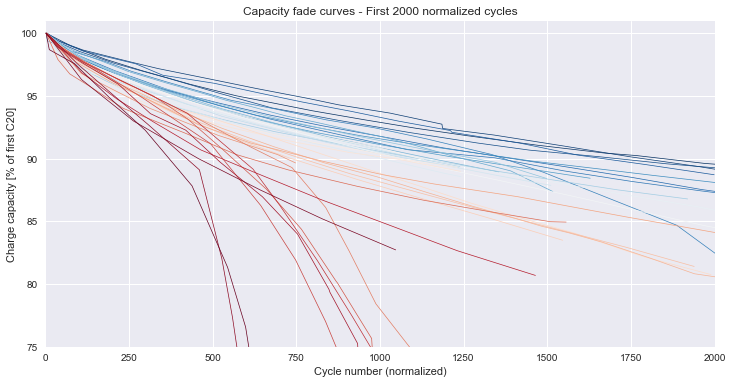

In [282]:
savepath = r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\overview"

group = 'All'

plt.style.use('seaborn')
plt.figure(figsize=(12,6))

cells_sorted = []
cl = []

for cell in bat_dict[group].keys():
    summary = bat_dict[group][cell]['summary']
    c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
    
    last = c20['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()
    if(last):
        cl.append(last[0])

cl = np.array(cl)
cl = np.sort(cl)[::-1]
cl_norm = minmax_scale(np.linspace(2500,0, len(cl)))
print(len(cl))

colormap = mpl.cm.ScalarMappable(cmap='RdBu')
colors = colormap.to_rgba(cl_norm)

for i in range(len(cl)):
    for cell in bat_dict[group].keys():
        summary = bat_dict[group][cell]['summary']
        c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
        last = c20['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()
        if(last):
            if(last[0] == cl[i]):
                
                plt.plot(c20['Cycle - total - normalized'], c20['Ah_cha (C20 first) (%)'], label=cell, linewidth=0.7, color=colors[i]) #Ah_cha (C20 first) (%)
                plt.xlabel('Cycle number (normalized)')
                plt.ylabel('Charge capacity [% of first C20]')
                plt.xlim(0,2000)
                plt.ylim(75,101)
                #plt.ylim(55,66.5)
plt.title('Capacity fade curves - First 2000 normalized cycles')
plt.savefig(os.path.join(savepath, 'capfade.png'))
plt.show()

## Correlation between charge capacity and cycle life

- If very high correlation --> linear degradation, no need for machine learning

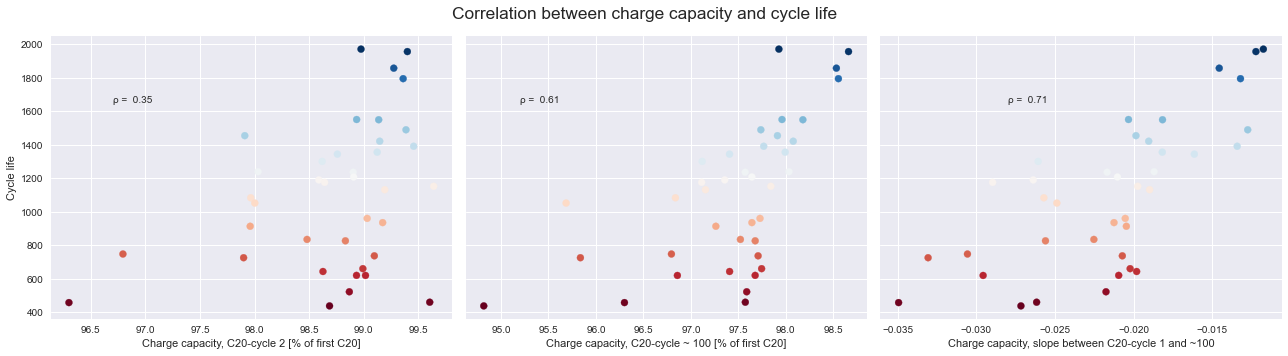

In [243]:
c20_first_Qd = []
c20_100_Qd = []
slope = []
cycle_lives = []
cycle = 'Cycle - total - normalized'

fig, ax = plt.subplots(ncols=3, figsize=(18,5), sharey=True)
for i in range(len(cl)):
    for cell in bat_dict[group].keys():
        summary = bat_dict[group][cell]['summary']
        c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
        last = c20['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()
        if(last):
            if(last[0] == cl[i]):

                boolarr = c20[cycle].between(90, 200) # This varies between groups and must be tuned
                firstTrue = np.where(boolarr==True)
                ind = firstTrue[0][0]
                cycle_diff = c20.iloc[ind][cycle] - c20.iloc[0][cycle]


                c20_first_Qd.append(c20.iloc[1]['Ah_cha (C20 first) (%)'])
                c20_100_Qd.append(c20.iloc[ind]['Ah_cha (C20 first) (%)'])
                slope.append((c20.iloc[ind]['Ah_cha (C20 first) (%)'] - c20.iloc[0]['Ah_cha (C20 first) (%)'])/cycle_diff)
                
                
                cycle_lives.append(last[0])
                
corrcoef1 = np.corrcoef(cycle_lives, c20_first_Qd)
corrcoef2 = np.corrcoef(cycle_lives, c20_100_Qd)
corrcoef3 = np.corrcoef(cycle_lives, slope)

                
ax[0].scatter(c20_first_Qd, cycle_lives, c=cycle_lives, cmap='RdBu')
ax[1].scatter(c20_100_Qd, cycle_lives, c=cycle_lives, cmap='RdBu')
ax[2].scatter(slope, cycle_lives, c=cycle_lives, cmap='RdBu')

                
ax[0].set_xlabel('Charge capacity, C20-cycle 2 [% of first C20]')
ax[0].text(96.7, 1650, f"\u03C1 =  {corrcoef1[1,0]:.2f}")

ax[1].set_xlabel('Charge capacity, C20-cycle ~ 100 [% of first C20]')
ax[1].text(95.2, 1650, f"\u03C1 =  {corrcoef2[1,0]:.2f}")

ax[2].set_xlabel('Charge capacity, slope between C20-cycle 1 and ~100')
ax[2].text(-0.028, 1650, f"\u03C1 =  {corrcoef3[1,0]:.2f}")

ax[0].set_ylabel('Cycle life')
                
plt.suptitle('Correlation between charge capacity and cycle life', fontsize='xx-large')
plt.tight_layout()
plt.savefig(os.path.join(savepath, 'capacity_correlation.png'))
plt.show()

<AxesSubplot:xlabel='Ah_balance (normalized)'>

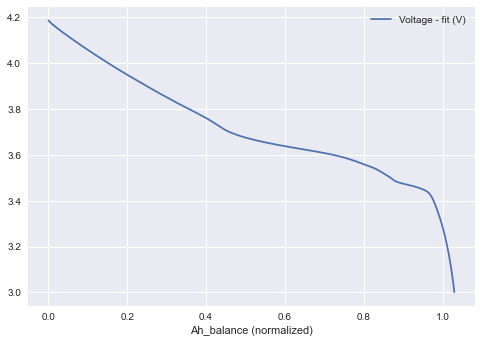

In [265]:
bat_dict['T25']['Cell_ID_SK04A2D007']['C20 discharge'][0].plot(x = 'Ah_balance (normalized)' , y = 'Voltage - fit (V)')

# Correlation between discharge capacity vs voltage and cycle life

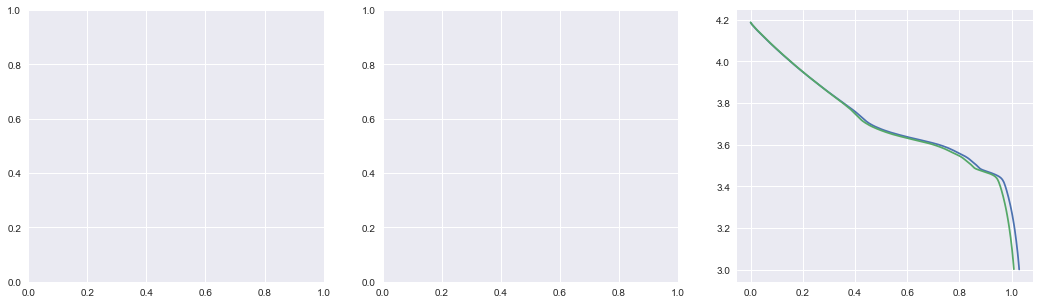

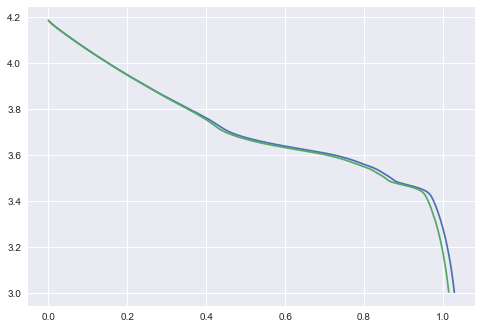

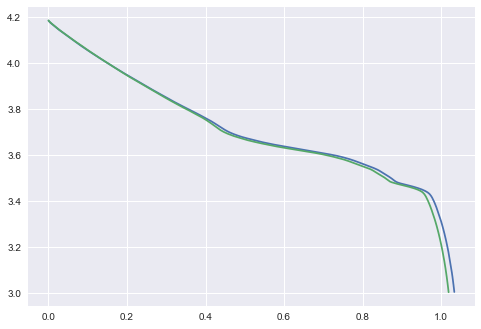

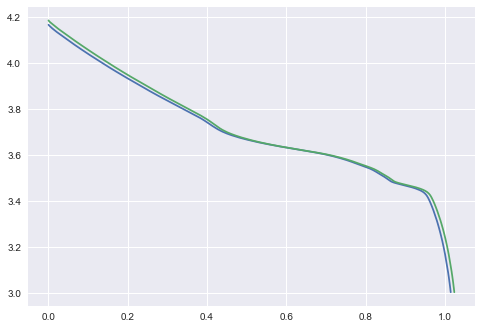

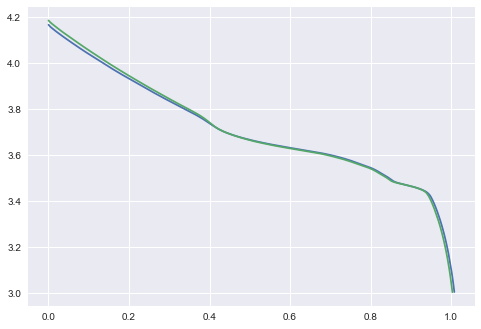

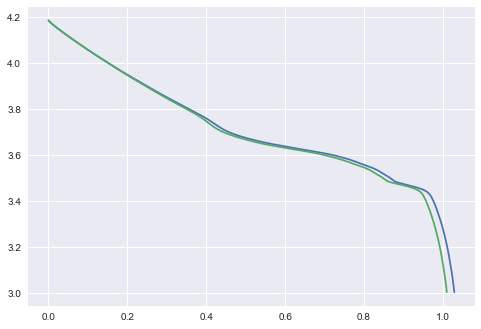

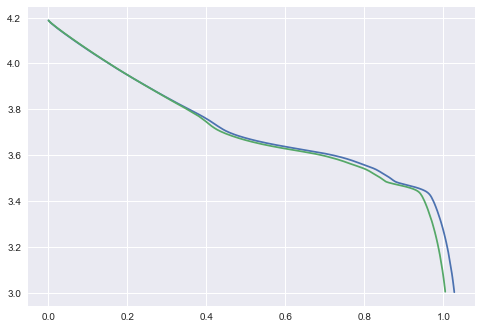

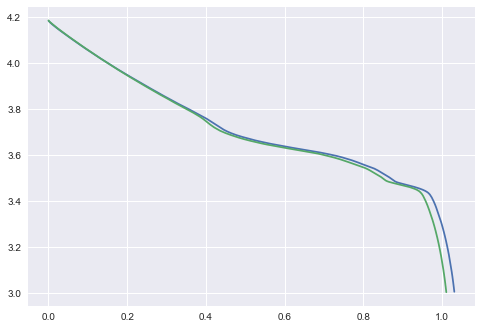

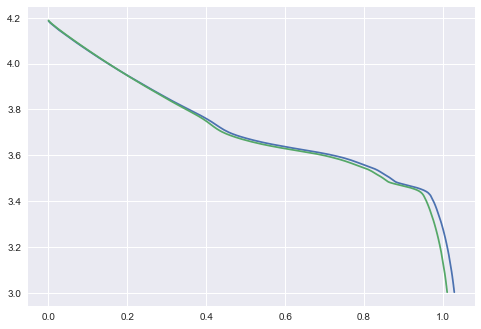

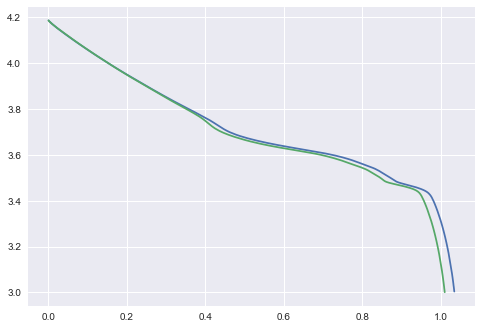

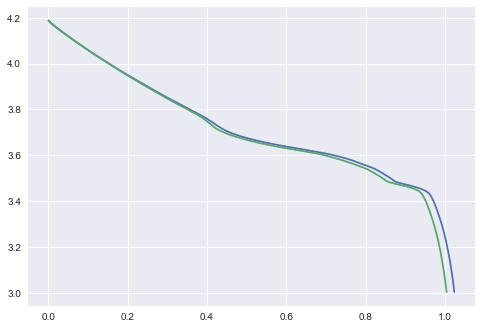

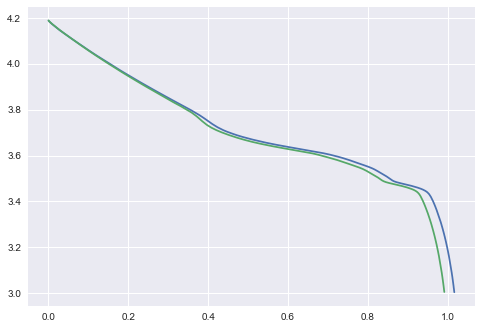

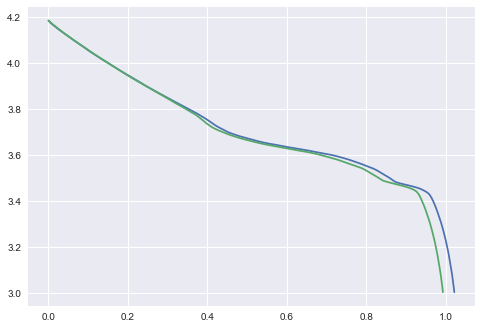

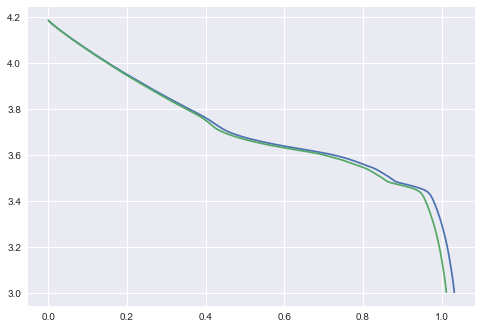

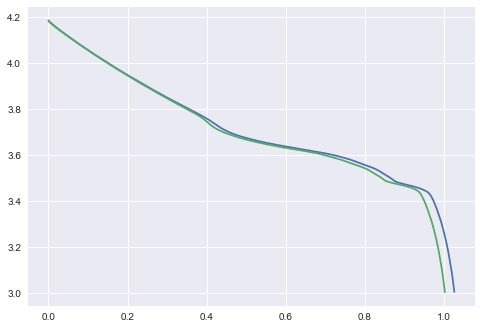

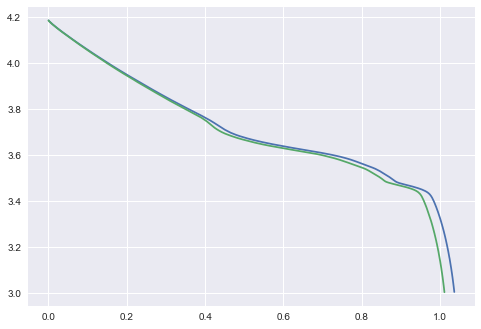

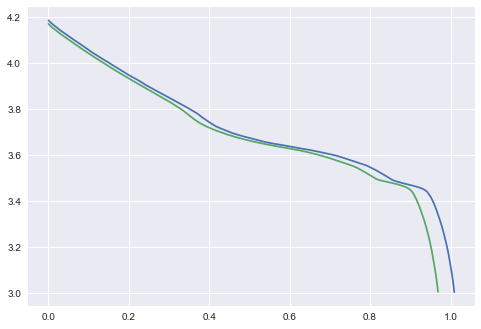

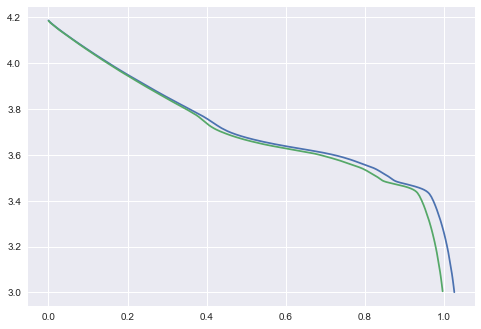

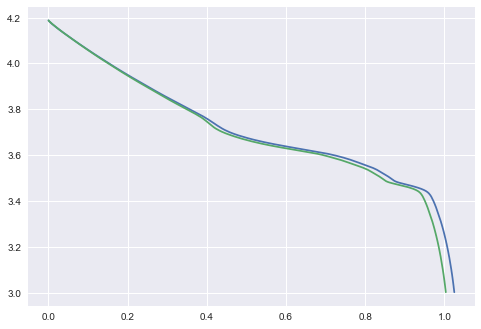

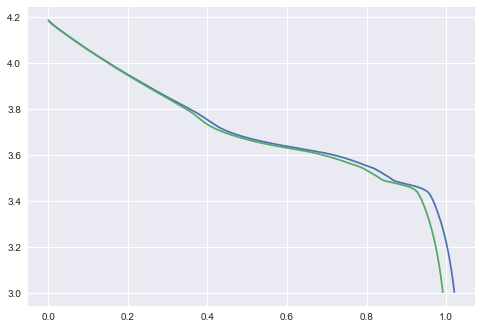

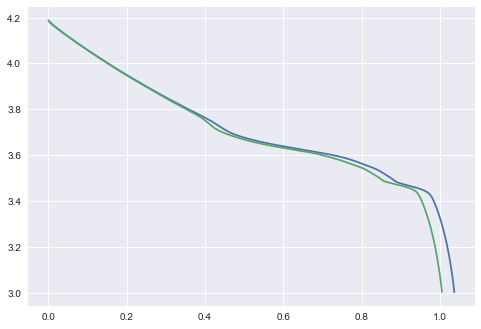

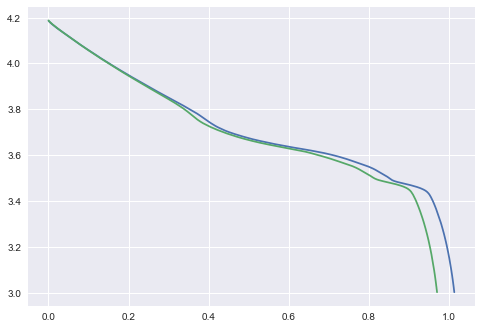

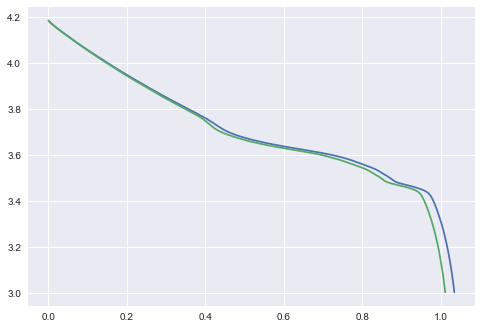

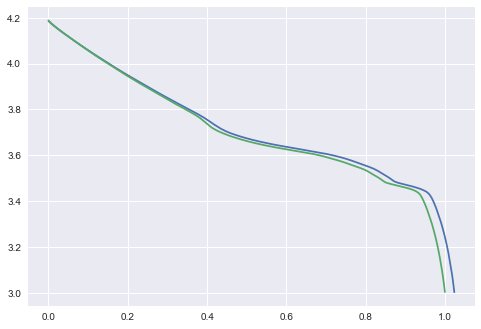

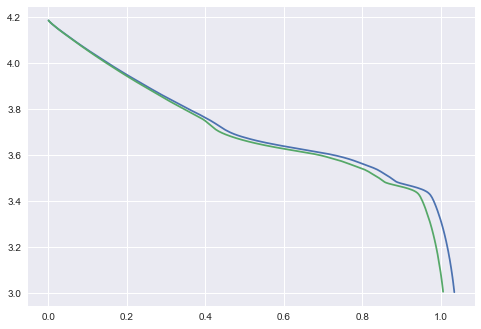

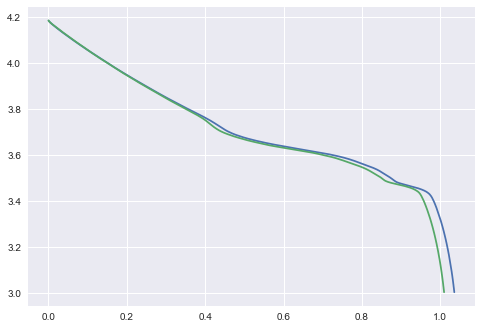

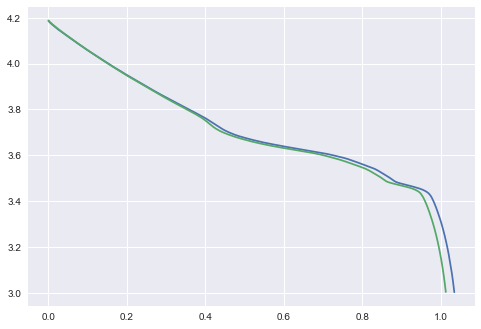

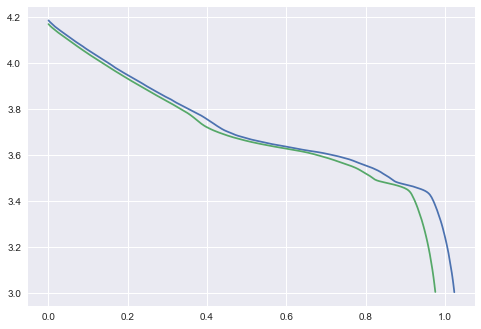

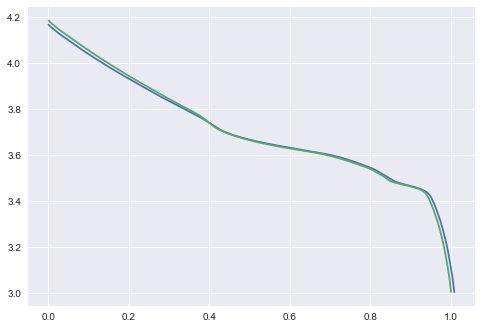

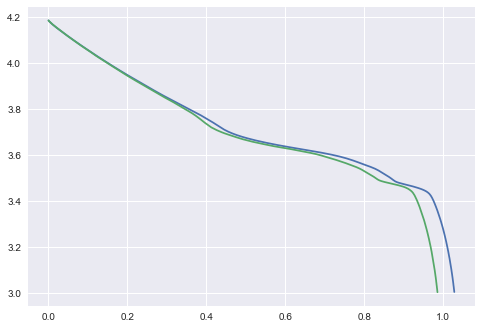

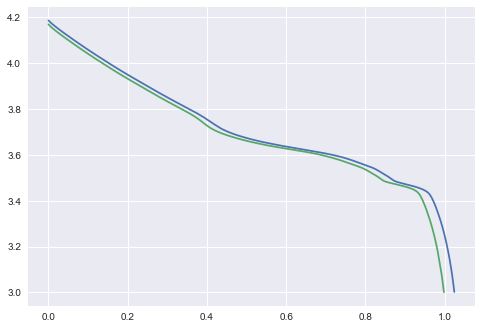

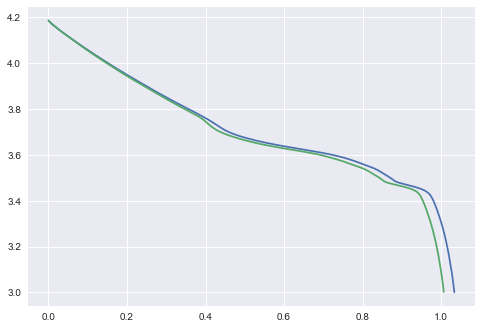

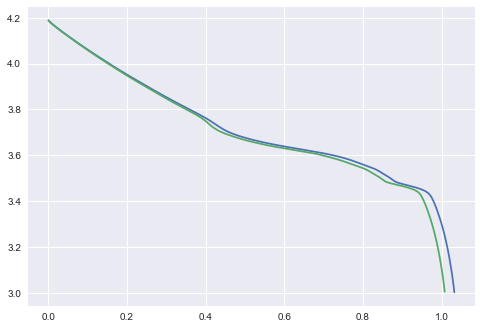

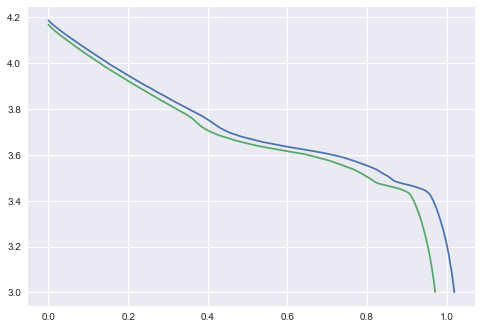

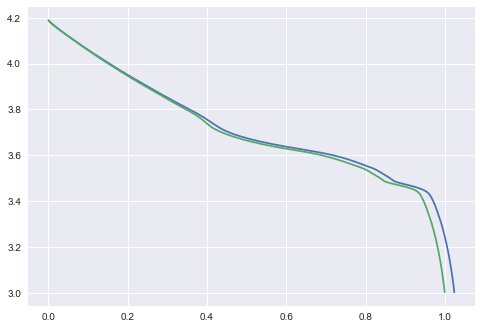

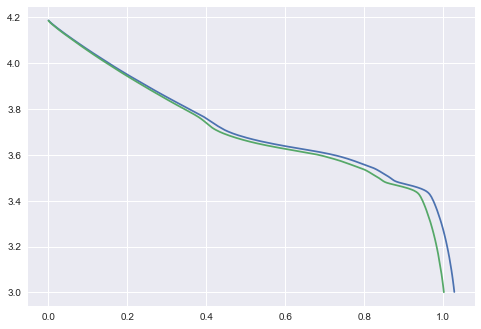

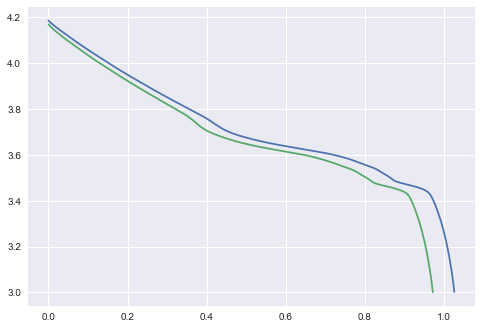

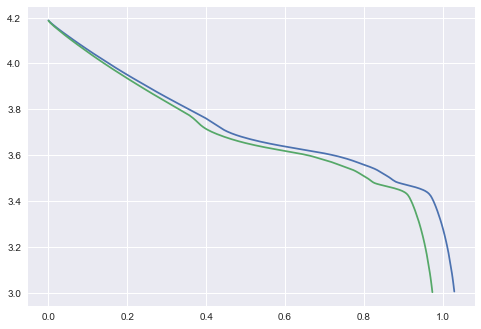

<Figure size 576x396 with 0 Axes>

In [267]:
diff = []
variance = []
mean = []
lives = []
group = 'All'
fig, ax = plt.subplots(ncols=3, figsize=(18,5))
for i in range(len(cl)):
    for cell in bat_dict[group].keys():
        summary = bat_dict[group][cell]['summary']
        c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
        c20_Qd = bat_dict[group][cell]['C20 discharge']
        last = c20['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()
        if(last):
            if(last[0] == cl[i]): # If cycle life in cell is equal to the cycle life in sorted list
                
                boolarr = c20[cycle].between(90, 200) # This varies between groups and must be tuned
                firstTrue = np.where(boolarr==True)
                ind = firstTrue[0][0]
                cycle_diff = c20.iloc[ind]['Cycle - total - normalized'] - c20.iloc[0]['Cycle - total - normalized']
                
                c20_first_Qd = c20_Qd[0]['Ah_balance (normalized)'].values 
                c20_100_Qd = c20_Qd[ind]['Ah_balance (normalized)'].values
                c20_first_v = c20_Qd[0]['Voltage - fit (V)'].values
                c20_100_v = c20_Qd[ind]['Voltage - fit (V)'].values
                
                plt.plot(c20_first_Qd, c20_first_v, label='Cycle 3')
                plt.plot(c20_100_Qd, c20_100_v, label='Cycle ~100')
                plt.show()
                
                # if different length, use only length of shortest array (should interpolate instead)
                if(len(c20_first_Qd) < len(c20_100_Qd)):
                    c20_Qd_diff = c20_100_Qd[:len(c20_first_Qd)] - c20_first_Qd
                    c20_Qd_diff_rel = (c20_100_Qd[:len(c20_first_Qd)] - c20_first_Qd)/cycle_diff
                elif(len(c20_first_Qd) > len(c20_100_Qd)):
                    c20_Qd_diff = c20_100_Qd - c20_first_Qd[:len(c20_100_Qd)]
                    c20_Qd_diff_rel = (c20_100_Qd - c20_first_Qd[:len(c20_100_Qd)])/cycle_diff
                else:
                    c20_Qd_diff = c20_100_Qd - c20_first_Qd
                    c20_Qd_diff_rel = (c20_100_Qd - c20_first_Qd)/cycle_diff
                
                lives.append(last[0])
                
                variance.append(np.log10(np.var(c20_Qd_diff_rel)))
                mean.append(np.log10(abs(np.mean(c20_Qd_diff_rel))))
                
                

                ax[0].plot(c20_Qd_diff_rel, c20_first_v[:len(c20_Qd_diff_rel)], color=colors[i], linewidth=1)
                ax[0].set_xlim(-0.0007, 0.0001)
                ax[0].set_xticks([-0.0007, -0.0005, -0.0003, -0.0001, 0.0001])

ax[0].set_xlabel('Relativized difference in $Q_{~100-3}$')
ax[0].set_ylabel('Voltage (V)')

corr_var = np.corrcoef(variance, lives)
ax[1].scatter(variance, lives, c=lives, cmap='RdBu')
ax[1].set_xlabel('log10($var(Q_{~100-3})$)')
ax[1].set_ylabel('Cycle life')
ax[1].text(-7.55, 1850, f"\u03C1 =  {corr_var[1,0]:.2f}")

corr_mean = np.corrcoef(mean, lives)
ax[2].scatter(mean, lives, c=lives, cmap='RdBu')
ax[2].set_xlabel('log10($mean(Q_{~100-3})$)')
ax[2].set_ylabel('Cycle life')
ax[2].text(-3.65, 1850, f"\u03C1 =  {corr_mean[1,0]:.2f}")
plt.suptitle('Correlation of $Q_{~100-3} (V) $ features and cycle life')
plt.savefig(os.path.join(savepath, 'Q100-3.png'))
plt.show()

## Make function for generating model features


***Notes***

- Could be more tidy to save this data as files and import them in a seperate script for modeling
    - Could do variance/mean etc in this cell and save them as raw features, then try ML with raw, log-transformed, sqrt-transformed etc
    - Alternatively: Gather all the data in one dataframe, with a column for each feature (and one for cell name)
- Specify cycling group, transform (original og log) and cycle type (regular or normalized)


In [325]:
def generate_features(group, transform, cycle_type = 'Cycle - total - normalized'):
    
    # Cycle lives
    cycle_lives = []

    # C20
    Qd_c20_fl = []
    Qd_c20_fl_rel = []
    
    # dQdV
    dQdV_c20_fl = []
    dQdV_c20_fl_rel = []
    
    # Regular cycles
    Qd115_15 = []
    
    # IR
    R_DC = []
    IR_100 = []
    IR_diff = []
    
    # Capacity
    cap100 = []
    cap_diff = []

    group = group
    cycle = cycle_type

    for cell in bat_dict[group].keys():
        
        # Dataframes used for feature extraction
        summary = bat_dict[group][cell]['summary']
        #c20 = summary.loc[summary['Current_dch (C)'] == -0.05]
        c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
        c20_Qd = bat_dict[group][cell]['C20 discharge']
        IR = bat_dict[group][cell]['IR cycles']
        c15 = bat_dict[group][cell]['c15']
        c115 = bat_dict[group][cell]['c115']
        c15_norm = bat_dict[group][cell]['c15 normalized']
        c115_norm = bat_dict[group][cell]['c115 normalized']

        # We define the cycle life as the cycle at which the capacity drops below 90% of the first measured c20 cycle capacity
        cl = c20.iloc[1:]['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()

        if(cl): # If the list is not empty aka cell goes under 90%


            # Find index of c20 cycle in interval
            boolarr = c20[cycle].between(90, 200) # This varies between groups and must be tuned
            firstTrue = np.where(boolarr==True)
            ind = firstTrue[0][0]
            cycle_diff = c20.iloc[ind][cycle] - c20.iloc[0][cycle]


            # ------------------------------------------ C20 DATA --------------------------------------
            
            c20_first_Qd = c20_Qd[0]['Ah_balance (normalized)'].values 
            c20_100_Qd = c20_Qd[ind]['Ah_balance (normalized)'].values


            # if different length, use only length of shortest array (should interpolate instead)
            if(len(c20_first_Qd) < len(c20_100_Qd)):
                c20_Qd_diff = c20_100_Qd[:len(c20_first_Qd)] - c20_first_Qd
                c20_Qd_diff_rel = (c20_100_Qd[:len(c20_first_Qd)] - c20_first_Qd)/cycle_diff
            elif(len(c20_first_Qd) > len(c20_100_Qd)):
                c20_Qd_diff = c20_100_Qd - c20_first_Qd[:len(c20_100_Qd)]
                c20_Qd_diff_rel = (c20_100_Qd - c20_first_Qd[:len(c20_100_Qd)])/cycle_diff
            else:
                c20_Qd_diff = c20_100_Qd - c20_first_Qd
                c20_Qd_diff_rel = (c20_100_Qd - c20_first_Qd)/cycle_diff


            # ------------------------------------------ dQdV DATA ---------------------------------------

            # dQdV C20
            dQdV_first = c20_Qd[0]['dQ/dV (1/V)'].values 
            dQdV_last = c20_Qd[ind]['dQ/dV (1/V)'].values

            if(len(dQdV_first) < len(dQdV_last)):
                dQdV_diff = dQdV_last[:len(dQdV_first)] - dQdV_first
                dQdV_diff_rel = (dQdV_last[:len(dQdV_first)] - dQdV_first)/cycle_diff
            elif(len(dQdV_first) > len(dQdV_last)):
                dQdV_diff = dQdV_last - dQdV_first[:len(dQdV_last)]
                dQdV_diff_rel = (dQdV_last - dQdV_first[:len(dQdV_last)])/cycle_diff
            else:
                dQdV_diff = dQdV_last - dQdV_first
                dQdV_diff_rel = (dQdV_last - dQdV_first)/cycle_diff



            
            #--------------------------------- REGULAR CYCLING DATA --------------------------------------
            
            Qd15 = c15_norm['Ah_balance (normalized)'].values # Change to c15 to switch to actual cycles
            Qd115 = c115_norm['Ah_balance (normalized)'].values

            if(len(Qd15) < len(Qd115)):
                Qd_diff = Qd115[:len(Qd15)] - Qd15
            elif(len(Qd15) > len(Qd115)): 
                Qd_diff = Qd115 - Qd15[:len(Qd115)]
            else:
                Qd_diff = Qd115 - Qd15
            
            # ---------------------------------------- IR DATA --------------------------------------------
                
                
            IR_first = IR_cycles[0]['Ah_balance (normalized)'].values 
            IR_next = IR_cycles[ind]['Ah_balance (normalized)'].values

            IR_difference = IR_next[:39] - IR_first[:39]/cycle_diff

            
            
            # ---------------------------------------- CAPACITY DATA ---------------------------------------
            
            Q0 = c20.iloc[0]['Ah_cha (C20 first) (%)']
            Q100 = c20.iloc[ind]['Ah_cha (C20 first) (%)']
            Qdiff = (Q100 - Q0)/cycle_diff



            # ----------------------------------------- Add to lists ----------------------------------------
            cycle_lives.append(cl[0])

            Qd_c20_fl.append(c20_Qd_diff)
            Qd_c20_fl_rel.append(c20_Qd_diff_rel)
            
            dQdV_c20_fl.append(dQdV_diff)
            dQdV_c20_fl_rel.append(dQdV_diff_rel)

            Qd115_15.append(Qd_diff)

            IR_diff.append(IR_difference)
            
            cap100.append(Q100)
            cap_diff.append(Qdiff)


    # ------------------------------------------------ Generate features --------------------------------------

    X = np.zeros((len(cycle_lives), 17)) # samples x features
    y = np.zeros(len(cycle_lives)) # samples

    for i in range(len(Qd_c20_fl)):
        # cycle life
        y[i] = (cycle_lives[i])

        # C20 discharge voltage curve features
        X[i,0] = np.var(Qd_c20_fl_rel[i])
        X[i,1] = np.mean(Qd_c20_fl_rel[i])
        X[i,2] = iqr(Qd_c20_fl_rel[i])
        X[i,3] = iqr(Qd_c20_fl_rel[i], rng=(10, 90))

        # C20 discharge dQdV curve features
        X[i,4] = np.var(dQdV_c20_fl_rel[i]) 
        X[i,5] = np.mean(dQdV_c20_fl_rel[i])
        X[i,6] = iqr(dQdV_c20_fl_rel[i])
        X[i,7] = iqr(dQdV_c20_fl_rel[i], rng=(10, 90))

        # Regular cycle features
        X[i,8] = np.var(Qd115_15[i]) # Variance
        X[i,9] = np.mean(Qd115_15[i]) # Mean
        X[i,10] = iqr(Qd115_15[i])
        X[i,11] = iqr(Qd115_15[i], rng=(10,90))
        
        
        # IR cycle features
        X[i,12] = np.mean(IR_diff[i])
        X[i,13] = np.var(IR_diff[i])
        X[i,14] = iqr(IR_diff[i])
        X[i,15] = iqr(IR_diff[i], rng=(10,90))
        
        # Capacity related features
        X[i,16] = cap_diff[i]

    if(transform == 'log'):
        X = np.log10(abs(X))
    else:
        X = X
    
    print('Number of cells: ', len(cycle_lives))
    
    return X, y

## Generate features for a group and plot correlation

In [326]:
X, y = generate_features('All', transform='log')

Number of cells:  38


In [327]:
for i in range(X.shape[1]):
    corr = np.round(np.corrcoef(X[:,i], y), decimals=2)
    print(i, corr[1][0])

0 -0.52
1 -0.7
2 -0.56
3 -0.55
4 -0.21
5 -0.63
6 -0.37
7 -0.21
8 -0.16
9 -0.16
10 -0.26
11 -0.15
12 0.01
13 0.0
14 0.01
15 0.01
16 -0.75


Pearson correlation coefficient:  -0.5155134623585714


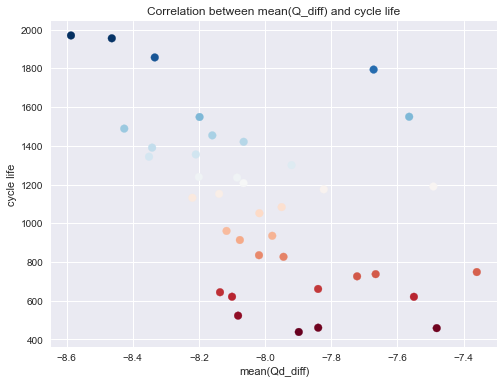

In [328]:
corr = np.corrcoef((X[:,0]), y)
print('Pearson correlation coefficient: ', corr[1][0])

plt.figure(figsize=(8,6))
plt.scatter(X[:,0], y, c=y, cmap='RdBu', s=60)
plt.xlabel('mean(Qd_diff)')
plt.ylabel('cycle life')
plt.title('Correlation between mean(Q_diff) and cycle life')
plt.show()

# ML models

- Hyperparameters are tuned using GridSearchCV
- Prediction of one group - trained on all vs trained on group
- Prediction of all and without T5

notater:
- k-fold 
    - høy k betyr små test-set og vice-versa
- Error metrics:
    - MSE og RMSE mer straffende mot store feil (siden squared av stort tall blir stort)

## Finding optimal hyperparameters

In [329]:
X, y = generate_features('All', transform='log')
cv = 5

pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(tol = 0.01, max_iter=100000))])
params = {'l1_ratio': [0.1,0.3,0.5,0.7,0.9,0.95,0.99,1], 'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 10, 100, 100]}
gs_en = GridSearchCV(pipe_EN[1], params, cv=cv, scoring='neg_root_mean_squared_error')
gs_en.fit(X, y)
print("Best parameters for EN (CV score=%0.3f):" % gs_en.best_score_)
print(gs_en.best_params_)
print("")

Number of cells:  38
Best parameters for EN (CV score=-336.805):
{'alpha': 0.5, 'l1_ratio': 0.95}



## Define function to train and test on chosen groups

In [82]:
def predict(train_group, test_group, transform):
    X_train, y_train = generate_features(train_group, transform=transform)
    X_test, y_test = generate_features(test_group, transform=transform)
    
    pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(max_iter=100000, tol=0.01, l1_ratio=0.95, alpha=0.5))])

    pipe_EN.fit(X_train, y_train)
    
    ypred_train = pipe_EN.predict(X_train)
    ypred_test = pipe_EN.predict(X_test)
    
    return y_train, ypred_train, y_test, ypred_test

## General vs specific training models

Number of cells:  38
Number of cells:  32
Number of cells:  32
Number of cells:  32


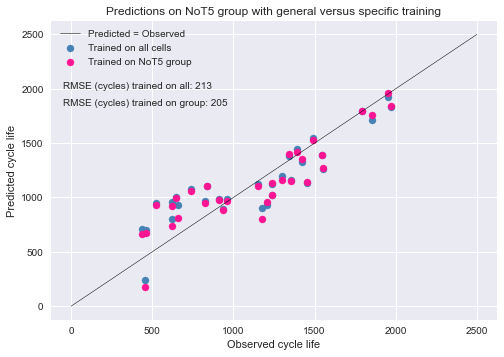

Number of cells:  38
Number of cells:  22
Number of cells:  32
Number of cells:  22


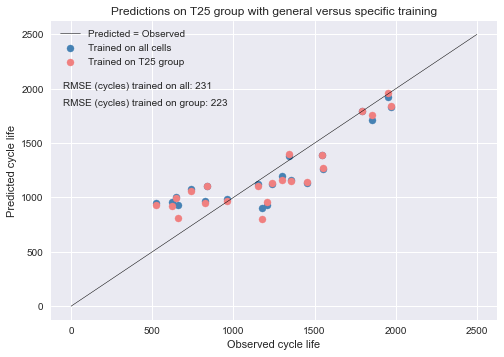

Number of cells:  38
Number of cells:  6
Number of cells:  32
Number of cells:  6


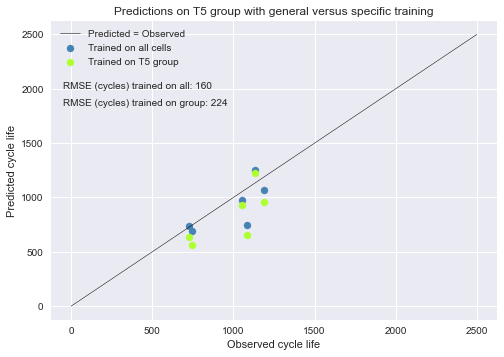

Number of cells:  38
Number of cells:  25
Number of cells:  32
Number of cells:  25


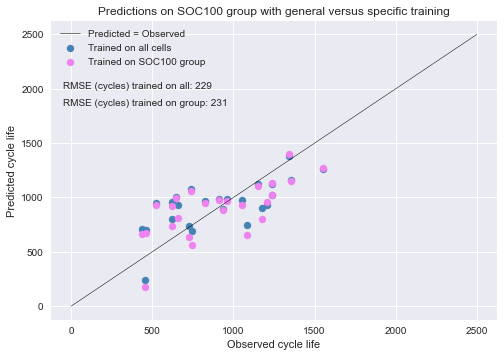

Number of cells:  38
Number of cells:  28
Number of cells:  32
Number of cells:  28


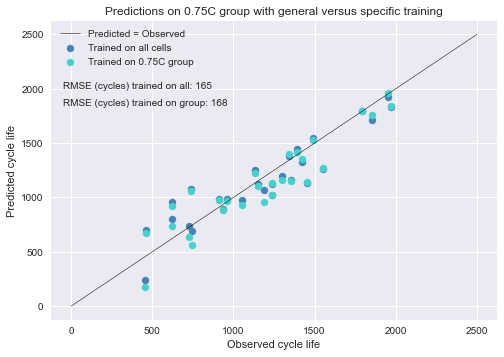

In [83]:
x_line = np.linspace(0,2500)
y_line = np.linspace(0,2500)

# No T5
y_train_all, ypred_train_all, y_test_all, ypred_test_all = predict('All', 'NoT5', 'log')
y_train_sel, ypred_train_sel, y_test_sel, ypred_test_sel = predict('NoT5', 'NoT5', 'log')

rmse_test_all = round(mean_squared_error(y_test_all, ypred_test_all, squared=False))
rmse_test_sel = round(mean_squared_error(y_test_sel, ypred_test_sel, squared=False))
s1 = 'RMSE (cycles) trained on all: '+ str(rmse_test_all)
s2 = 'RMSE (cycles) trained on group: ' + str(rmse_test_sel)

plt.plot(x_line, y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_test_all, ypred_test_all, color='steelblue', s=50, label='Trained on all cells')
plt.scatter(y_test_sel, ypred_test_sel, color='deeppink', s=50, label='Trained on NoT5 group')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(-50,2000, s1)
plt.text(-50,1850, s2)
plt.legend()
plt.title('Predictions on NoT5 group with general versus specific training')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\tren_all_vs_group\NoT5.jpg")
plt.show()

# T25
y_train_all, ypred_train_all, y_test_all, ypred_test_all = predict('All', 'T25', 'log')
y_train_sel, ypred_train_sel, y_test_sel, ypred_test_sel = predict('NoT5', 'T25', 'log')

rmse_test_all = round(mean_squared_error(y_test_all, ypred_test_all, squared=False))
rmse_test_sel = round(mean_squared_error(y_test_sel, ypred_test_sel, squared=False))
s1 = 'RMSE (cycles) trained on all: '+ str(rmse_test_all)
s2 = 'RMSE (cycles) trained on group: ' + str(rmse_test_sel)

plt.plot(x_line, y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_test_all, ypred_test_all, color='steelblue', s=50, label='Trained on all cells')
plt.scatter(y_test_sel, ypred_test_sel, color='lightcoral', s=50, label='Trained on T25 group')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(-50,2000, s1)
plt.text(-50,1850, s2)
plt.legend()
plt.title('Predictions on T25 group with general versus specific training')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\tren_all_vs_group\T25.jpg")
plt.show()

# T5
y_train_all, ypred_train_all, y_test_all, ypred_test_all = predict('All', 'T5', 'log')
y_train_sel, ypred_train_sel, y_test_sel, ypred_test_sel = predict('NoT5', 'T5', 'log')

rmse_test_all = round(mean_squared_error(y_test_all, ypred_test_all, squared=False))
rmse_test_sel = round(mean_squared_error(y_test_sel, ypred_test_sel, squared=False))
s1 = 'RMSE (cycles) trained on all: '+ str(rmse_test_all)
s2 = 'RMSE (cycles) trained on group: ' + str(rmse_test_sel)

plt.plot(x_line, y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_test_all, ypred_test_all, color='steelblue', s=50, label='Trained on all cells')
plt.scatter(y_test_sel, ypred_test_sel, color='greenyellow', s=50, label='Trained on T5 group')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(-50,2000, s1)
plt.text(-50,1850, s2)
plt.legend()
plt.title('Predictions on T5 group with general versus specific training')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\tren_all_vs_group\T5.jpg")
plt.show()

# SOC 100
y_train_all, ypred_train_all, y_test_all, ypred_test_all = predict('All', 'soc100', 'log')
y_train_sel, ypred_train_sel, y_test_sel, ypred_test_sel = predict('NoT5', 'soc100', 'log')

rmse_test_all = round(mean_squared_error(y_test_all, ypred_test_all, squared=False))
rmse_test_sel = round(mean_squared_error(y_test_sel, ypred_test_sel, squared=False))
s1 = 'RMSE (cycles) trained on all: '+ str(rmse_test_all)
s2 = 'RMSE (cycles) trained on group: ' + str(rmse_test_sel)

plt.plot(x_line, y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_test_all, ypred_test_all, color='steelblue', s=50, label='Trained on all cells')
plt.scatter(y_test_sel, ypred_test_sel, color='violet', s=50, label='Trained on SOC100 group')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(-50,2000, s1)
plt.text(-50,1850, s2)
plt.legend()
plt.title('Predictions on SOC100 group with general versus specific training')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\tren_all_vs_group\soc100.jpg")
plt.show()

# 
y_train_all, ypred_train_all, y_test_all, ypred_test_all = predict('All', '075C', 'log')
y_train_sel, ypred_train_sel, y_test_sel, ypred_test_sel = predict('NoT5', '075C', 'log')

rmse_test_all = round(mean_squared_error(y_test_all, ypred_test_all, squared=False))
rmse_test_sel = round(mean_squared_error(y_test_sel, ypred_test_sel, squared=False))
s1 = 'RMSE (cycles) trained on all: '+ str(rmse_test_all)
s2 = 'RMSE (cycles) trained on group: ' + str(rmse_test_sel)

plt.plot(x_line, y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_test_all, ypred_test_all, color='steelblue', s=50, label='Trained on all cells')
plt.scatter(y_test_sel, ypred_test_sel, color='mediumturquoise', s=50, label='Trained on 0.75C group')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(-50,2000, s1)
plt.text(-50,1850, s2)
plt.legend()
plt.title('Predictions on 0.75C group with general versus specific training')
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\tren_all_vs_group\075C.jpg")
plt.show()


## Model for single prediction (DONT USE THIS CELL, DO WITHOUT CROSS VALIDATION)

In [ ]:
k = 5
kfold = KFold(n_splits=k, shuffle=True)

X,y = generate_features('All', transform='log')

Xtr, Xte, ytr, yte = train_test_split(X,y)

rmse_train = np.zeros(k)
rmse_test = np.zeros(k)

mae_train = np.zeros(k)
mae_test = np.zeros(k)

mape_train = np.zeros(k)
mape_test = np.zeros(k)

r2_train = np.zeros(k)
r2_test = np.zeros(k)

i=0

for train_ind, test_ind in kfold.split(Xtr, ytr):
    X_train, X_test = X[train_ind], X[test_ind]
    y_train, y_test = y[train_ind], y[test_ind]
    
    pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(l1_ratio=0.95, alpha=0.5, max_iter=100000, tol=0.001))])
    
    pipe_EN.fit(X_train, y_train)
    ypred_train = pipe_EN.predict(X_train)
    ypred_test = pipe_EN.predict(X_test)
    
    rmse_train[i] = mean_squared_error(y_train, ypred_train, squared=False)
    rmse_test[i] = mean_squared_error(y_test, ypred_test, squared=False)
    
    mae_train[i] = mean_absolute_error(y_train, ypred_train)
    mae_test[i] = mean_absolute_error(y_test, ypred_test)
    
    r2_train[i] = r2_score(y_train, ypred_train)
    r2_test[i] = r2_score(y_test, ypred_test)
    
    mape_train[i] = mean_absolute_percentage_error(y_train, ypred_train)
    mape_test[i] = mean_absolute_percentage_error(y_test, ypred_test)
    
    print('RMSE: ', np.round(rmse_train[i]), np.round(rmse_test[i]))
    print('')
    
    print('MAE: ', np.round(mae_train[i]), np.round(mae_test[i]))
    print('')
    
    print('R2: ', np.round(r2_train[i], decimals=4), np.round(r2_test[i], decimals=4))
    print('')
    
    print('MAPE: ', np.round(100*mape_train[i]), np.round(100*mape_test[i]))
    print("")
    print("")
    print("")
    
    
    i += 1


rmse_train_mean = int(np.mean(rmse_train)) 
rmse_test_mean = int(np.mean(rmse_test))

mae_train_mean = int(np.mean(mae_train))
mae_test_mean = int(np.mean(mae_test))

r2_train_mean = np.round(np.mean(r2_train), decimals=4)
r2_test_mean = np.round(np.mean(r2_test), decimals=4)

mape_train_mean = np.round(100*np.mean(mape_train))
mape_test_mean = np.round(100*np.mean(mape_test))


print('RMSE mean: ', rmse_train_mean, rmse_test_mean)
print('MAE mean: ', mae_train_mean, mae_test_mean)
print('R2 mean: ', r2_train_mean, r2_test_mean)
print('MAPE mean: ', mape_train_mean, mape_test_mean)

prediction = pipe_EN.predict(Xte)
rmse_final = mean_squared_error(yte, prediction, squared=False)
print("PREDICTION ON TEST DATA: ", rmse_final)

# Use this for full model

In [332]:
# Generate features and targets and split into train/test
X,y = generate_features('All', transform='log')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

# Create model and fit 
pipe_EN = Pipeline([('scaler', StandardScaler()), ('estimator', ElasticNet(l1_ratio=0.95, alpha=0.5, max_iter=100000, tol=0.001))])
pipe_EN.fit(X_train, y_train)

# Make predictions
ypred_train = pipe_EN.predict(X_train)
ypred_test = pipe_EN.predict(X_test)

# Get errors
rmse_train = round(mean_squared_error(y_train, ypred_train, squared=False))
rmse_test = round(mean_squared_error(y_test, ypred_test, squared=False))

mae_train = round(mean_absolute_error(y_train, ypred_train))
mae_test = round(mean_absolute_error(y_test, ypred_test))

r2_train = np.round(r2_score(y_train, ypred_train), decimals=2)
r2_test = np.round(r2_score(y_test, ypred_test), decimals=2)

mape_train = np.round(100*mean_absolute_percentage_error(y_train, ypred_train), decimals=1)
mape_test = np.round(100*mean_absolute_percentage_error(y_test, ypred_test), decimals=1)

# Print errors
print('RMSE mean: ', rmse_train, rmse_test)
print('MAE mean: ', mae_train, mae_test)
print('R2 mean: ', r2_train, r2_test)
print('MAPE mean: ', mape_train, mape_test)

Number of cells:  38
RMSE mean:  215 205
MAE mean:  182 155
R2 mean:  0.72 0.69
MAPE mean:  22.8 11.9


In [181]:
# Coefficients of features
print(pipe_EN[1].coef_)

[ -93.10299543 -131.65215652  228.39192862 -176.58206792  100.62578775
 -230.42344919  255.10391131  -73.74190795   25.23859723  -10.04060215
 -153.66713802   99.98342853   -8.97490551   22.26726974    0.
    1.62414638 -133.34713645]


In [288]:
print(len(y_train))

30


<ipython-input-268-d5d981563048>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(names)


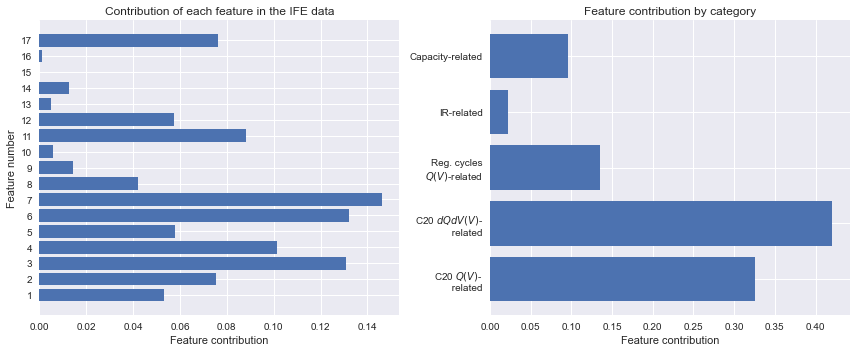

In [268]:
# Each feature
ypos1 = np.arange(1,18)
f = abs(pipe_EN[1].coef_)
fnorm = f/sum(f)

# Feature categories
c20_Q = sum(fnorm[0:3])
c20_dQdV = sum(fnorm[4:7])
reg_cyc = sum(fnorm[8:11])
IR = sum(fnorm[12:15])
cap = fnorm[16]

importance = [c20_Q, c20_dQdV, reg_cyc, IR, cap]
imp_norm = importance/sum(importance)
ypos2 = np.arange(5)

#names = ('C20 $Q_{100-3}(V)$', 'C20 $dQdV_{100-3}(V)$ ', 'Regular $Q_{115-15}$', '$IR_{101-4}$', 'Capacity')
names = ['C20 $Q(V)$-\n related', 'C20 $dQdV(V)$-\n related', 'Reg. cycles\n$Q(V)$-related', 'IR-related', 'Capacity-related']

fig,ax = plt.subplots(ncols=2, figsize=(12,5))

ax[0].barh(ypos1, fnorm)
ax[0].set_yticks(np.arange(1,18))
ax[0].set_xlabel('Feature contribution')
ax[0].set_ylabel('Feature number')
ax[0].set_title('Contribution of each feature in the IFE data')

ax[1].barh(ypos2, imp_norm)
ax[1].set_yticklabels(names)
ax[1].set_yticks(ypos)
ax[1].set_xlabel('Feature contribution')
ax[1].set_title('Feature contribution by category')
plt.tight_layout()
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\f_cont.png")
plt.show()


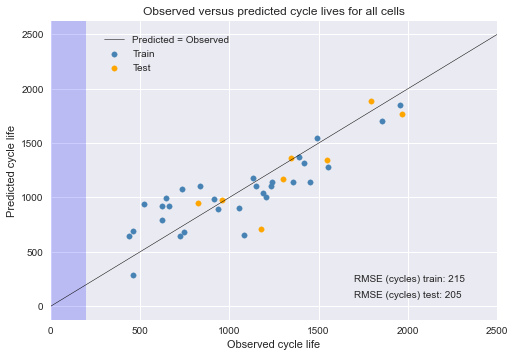

In [88]:
x_line = np.linspace(0,2500)
y_line = np.linspace(0,2500)

s1 = 'RMSE (cycles) train: '+ str(rmse_train)
s2 = 'RMSE (cycles) test: ' + str(rmse_test)

plt.scatter(y_train, ypred_train, color='steelblue', s=30, label='Train')
plt.scatter(y_test, ypred_test, color='orange', s=30, label='Test')
plt.plot(x_line,y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.text(1700, 230, s1)
plt.text(1700, 80, s2)
plt.legend(loc = 'upper left', bbox_to_anchor=(0.1, 0.88, 0.1, 0.1))
plt.xlim(0,2500)
plt.title('Observed versus predicted cycle lives for all cells')
plt.axvspan(0, 200, facecolor='b', alpha=0.2)
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\final_pred.png")
plt.show()

## Compare results to a linear regression of capacity fade betwee cycle 1 and 115

1105.4211315789476
RMSE mean:  201 224
MAE mean:  154 191
R2 mean:  0.76 0.63
MAPE mean:  19.1 13.1


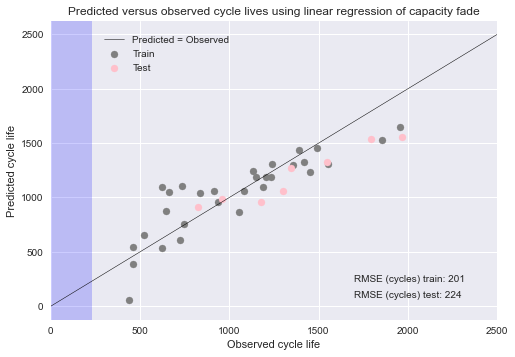

In [323]:
from sklearn.linear_model import LinearRegression

y = np.zeros((38))
X = np.zeros((38))

cycle = 'Cycle - total - normalized'

i=0
for cell in bat_dict[group].keys():
    summary = bat_dict[group][cell]['summary']
    c20 = summary.loc[(summary['Current_dch (C)'] == -0.05) & (summary['Voltage EoC (V)'] > 4.19) & (summary['Voltage EoD (V)'] < 3.01) & (summary['CE (%)'].between(90,110))]
    
    last = c20['Cycle - total - normalized'][c20['Ah_cha (C20 first) (%)'] < 90].tolist()
    if(last):
        y[i] = last[0]
        
      
        boolarr = c20[cycle].between(300, 500) # This varies between groups and must be tuned
        firstTrue = np.where(boolarr==True)
        ind = firstTrue[0][0]
        
        cycle_diff = c20.iloc[ind][cycle] - c20.iloc[0][cycle]
        
        X[i] = (c20.iloc[0]['Ah_cha (C20 first) (%)'] - c20.iloc[ind]['Ah_cha (C20 first) (%)'])/cycle_diff
        
        i += 1
        
linreg = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1),y, test_size=0.2, random_state=2)

linreg.fit(X_train.reshape(-1,1),y_train)
print(np.mean(y))

ypred_train = linreg.predict(X_train.reshape(-1,1))
ypred_test = linreg.predict(X_test.reshape(-1,1))

# Get errors
rmse_train = round(mean_squared_error(y_train, ypred_train, squared=False))
rmse_test = round(mean_squared_error(y_test, ypred_test, squared=False))

mae_train = round(mean_absolute_error(y_train, ypred_train))
mae_test = round(mean_absolute_error(y_test, ypred_test))

r2_train = np.round(r2_score(y_train, ypred_train), decimals=2)
r2_test = np.round(r2_score(y_test, ypred_test), decimals=2)

mape_train = np.round(100*mean_absolute_percentage_error(y_train, ypred_train), decimals=1)
mape_test = np.round(100*mean_absolute_percentage_error(y_test, ypred_test), decimals=1)

# Print errors
print('RMSE mean: ', rmse_train, rmse_test)
print('MAE mean: ', mae_train, mae_test)
print('R2 mean: ', r2_train, r2_test)
print('MAPE mean: ', mape_train, mape_test)


s1 = 'RMSE (cycles) train: '+ str(rmse_train)
s2 = 'RMSE (cycles) test: ' + str(rmse_test)

plt.plot(x_line,y_line, color='black', linewidth=0.5, label='Predicted = Observed')
plt.scatter(y_train, ypred_train, color='grey', label='Train')
plt.scatter(y_test, ypred_test, color='pink', label='Test')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.xlim(0,2500)
plt.text(1700, 230, s1)
plt.text(1700, 80, s2)
plt.legend(loc = 'upper left', bbox_to_anchor=(0.1, 0.88, 0.1, 0.1))
plt.title('Predicted versus observed cycle lives using linear regression of capacity fade')
plt.axvspan(0, 230, facecolor='b', alpha=0.2)
plt.savefig(r"C:\Users\ife12216\OneDrive - Institutt for Energiteknikk\Documents\Masteroppgave\ML_github\out\IFE\OvsP\linreg_benchmark.png")
plt.show()